Colab notebook for earthquake plotting using basemap

# 1. Montar Unidad de Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Instalar Modulos faltantes

## 2.1. Instalación de Basemap

In [2]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756170 sha256=3f69693263ae6d3f4f7439fbdd3da436125680675d142680d20c60507492b0f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-0r2bgz_n/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


#3. Importar librerías a usar

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import seaborn as sns

plt.rcParams.update({'font.size': 22, 'axes.labelsize':22})

# 4. Cargue de datos

## 4.1. Sismos usados en la optimización bayesiana

In [4]:
all_ev_path = '/content/drive/Shared drives/Automatic STA LTA optimizer/Datos/bayes_union_coords.csv'
df_all = pd.read_csv(all_ev_path, index_col=0)
df_all.sort_values(by='magnitude', ascending=False, inplace=True)
df_all.head()

lon    lat   prof  magnitude
publicID                                     
SGC2016bupm  -73.079  6.835  148.0        3.0
SGC2016avnb  -73.163  6.797  146.8        3.0
SGC2019chogn -73.190  6.842  139.4        3.0
SGC2016anwv  -73.129  6.808  142.0        2.9
SGC2019cpsub -72.784  5.668   -2.0        2.9

## 4.2. Coordenadas de las estaciones usadas

In [5]:
sta_path = '/content/drive/Shared drives/Automatic STA LTA optimizer/Datos/stations_sc3.csv'

# cargando el csv con las estaciones del SGC
df_sta = pd.read_csv(sta_path, names=['net', 'station', 'lat', 'lon', 'elev'])
# seleccionando solamente las estaciones de interés
df_sta = df_sta[df_sta['station']\
                .isin(['BAR2', 'BRJC', 'RUS', 'PAM',
                       'PTB', 'SPBC', 'YPLC', 'OCA'])]
df_sta

net station       lat        lon   elev
17   CM    BAR2  6.592000 -73.182000  1.864
22   CM    BRJC  6.973200 -73.744160  0.108
117  CM     OCA  8.238833 -73.319333  1.264
121  CM     PAM  7.339500 -72.699500  3.676
144  CM     PTB  6.539500 -74.456333  0.260
155  CM     RUS  5.892500 -73.083167  3.697
169  CM    SPBC  5.652167 -74.072333  0.783
191  CM    YPLC  5.396900 -72.380200  0.696

# 5. Creación del mapa

## 5.1. Función para la creación del mapa

In [15]:
def plot_eqt(df_all, lat_col='lat', lon_col='lon', depth_col='prof',
             mag_col='magnitude', cmap=sns.cm.crest, station_legend=False,
             df_sta=None, sta_lat='lat', sta_lon='lon', sta_color='r', ds=2,
             d_lat=1, d_lon=1, **kwargs):
  """Crea mapa de sismos escalando la profundidad con el color y la magnitud
  con el tamaño.

    Parameters
    ----------
    df_all : pandas.DataFrame
        DataFrame con la localización de los sismos a pintar 

    lat_col : str
        Nombre de la columna con la latitud de los sismos, default: "lat"

    lon_col : str
        Nombre de la columna con la longitud de los sismos, default: "lon"

    depth_col : str
        Nombre de la columna con la profundidad de los sismos, default: "prof"

    mag_col : str
        Nombre de la columna con la magnitud de los sismos, default: "magnitude"

    cmap : str or `~matplotlib.colors.Colormap`, default: `sns.cm.crest`
        Una instancia de Colormap o un nombre de Colormap registrado

    station_legend : bool
        Especifica si se pondrá la leyenda de estación. Se usa solo
        si se pasa un DataFrame en df_sta, default: False

    df_sta : pandas.DataFrame
        DataFrame con la localización de las estaciones a pintar

    sta_lat : str
        Nombre de la columna con la latitud de las estaciones, default: "lat"

    sta_lon : str
        Nombre de la columnta con la longitud de las estaciones, default: "lon"

    sta_color : str
        Nombre del color con el que se pintarán las estaciones, default: '"r"

    ds : int
        Grados alrededor de la latitud mínima y máxima de los simos, default: 2

    d_lat : int
        Separación en grados entre los paralelos a pintar, default: 1

    d_lon : int
        Separación en grados entre los meridianos a pintar, default: 1

    **kwargs : Los demás argumentos son pasados a matplotlib.pyplot.scatter 
        como propiedades estéticas de los simos y estaciones pintadas 
  """

  # Definiendo los bordes del mapa
  lat_min, lat_max = df_all[lat_col].min() - ds, df_all[lat_col].max() + ds
  lon_min, lon_max = df_all[lon_col].min() - ds, df_all[lon_col].max() + ds

  # Se crea una grilla de 4 filas y 6 columnas. El mapa principal se extenderá
  # sobre toda la grilla mientras que minimapa se ubicará en la casilla
  # inferior derecha
  fig2 = plt.figure(constrained_layout=True, figsize=(15*2, 8*2))
  spec2 = gridspec.GridSpec(nrows=4, ncols=6, figure=fig2)
  ax1 = fig2.add_subplot(spec2[:, :])

  # Se crea objeto Basemap del mapa principal
  m = Basemap(llcrnrlat=lat_min, urcrnrlat=lat_max, resolution=None,
              llcrnrlon=lon_min, urcrnrlon=lon_max, epsg=3117)
  # Se dibujan los sismos sobre el mapa principal escalando la profundidad
  # en el color y la magnitud con el tamaño (escala exponencial)
  m.scatter(df_all[lon_col].to_list(), df_all[lat_col].to_list(),
            latlon = True,
            c = df_all[depth_col].to_list(),
            s = (50 * (4 ** df_all[mag_col])),
            cmap = cmap,
            **kwargs)
  # Se crea la barra de color
  cbar = plt.colorbar(fraction=0.054, pad=0.04, aspect=40)
  cbar.set_label('Depth', fontsize=30, alpha=1, rotation=90, labelpad=27)

  # Si no se pasa DataFrame en df_sta no se pintan las estaciones en el mapa
  if df_sta is not None:
    m.scatter(df_sta[sta_lon].to_list(), df_sta[sta_lat].to_list(),
              latlon=True, s=500, marker="^", c=sta_color, **kwargs)

    if station_legend:
      # se crea un plot vació con las características de las estaciones para
      # asignarle la leyenda
      t1 = plt.scatter([],[], s=500, marker="^", c=sta_color, **kwargs)
      # Se crea la leyenda de las estaciones
      sta_legend = plt.legend([t1], ['stations'], ncol=1, fontsize=12, 
                loc='lower center', scatterpoints=1, labelspacing=3,
                handletextpad=3, borderaxespad=1, borderpad=2, prop={'size':18})
      # Se agrega la leyenda de las estaciones al Axis del mapa grande (ax1)
      ax1.add_artist(sta_legend)

  # Se descarga del servició de argis la topografía World_Shaded_Relief
  m.arcgisimage(service='World_Shaded_Relief', xpixels = 2000, verbose= False,dpi=1000)
  m.drawparallels(np.arange(lat_min, lat_max, d_lat),labels=[True,True,False,False],dashes=[2,2])
  m.drawmeridians(np.arange(lon_min, lon_max, d_lon),labels=[False,False,False,True],dashes=[2,2])

  # Se crea un Axis (ax2) al que se le asigna la casilla inferior derecha de
  # la grilla spec2 previamente creada
  ax2 = fig2.add_subplot(spec2[-1, -1])
  # Se crea objeto Basemap del mini mapa, se le asignan colores
  # y se le dibujan paises y costas
  m2 = Basemap(projection='ortho', lat_0=df_all[lat_col].mean(),
              lon_0=df_all[lon_col].mean(), resolution='i')
  m2.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
  m2.fillcontinents(color='grey', alpha=0.5)
  m2.drawcountries(linewidth=0.3, linestyle='solid')
  m2.drawcoastlines(linewidth=0.1, color='white')

  # Se pinta rectángulo rojo del mini mapa
  lats = [lat_min, lat_max, lat_max, lat_min,lat_min]
  lons = [lon_min, lon_min, lon_max, lon_max, lon_min]
  X, Y = m2(lons, lats)
  m2.plot(X, Y, color='red', marker=None)

  # Se crean 3 scatter plot vacios para la leyenda de las magnitudes. 
  # Uno por cada magnitud que se desee poner en la leyenda.
  l1 = plt.scatter([],[], s=(50 * (4 ** 1)), edgecolors='none', color='#555555')
  l2 = plt.scatter([],[], s=(50 * (4 ** 2)), edgecolors='none', color='#555555')
  l3 = plt.scatter([],[], s=(50 * (4 ** 3)), edgecolors='none', color='#555555')
  labels = ["1", "2", "3"]
  ax1.legend([l1, l2, l3], labels, ncol=1, fontsize=12, loc='lower left',
            title='Magnitude', scatterpoints=1, labelspacing=3, handletextpad=3,
            borderaxespad=1, borderpad=2, prop={'size':18})
  
  return m, ax1, m2, ax2

## 5.2. Mapa solo sismos

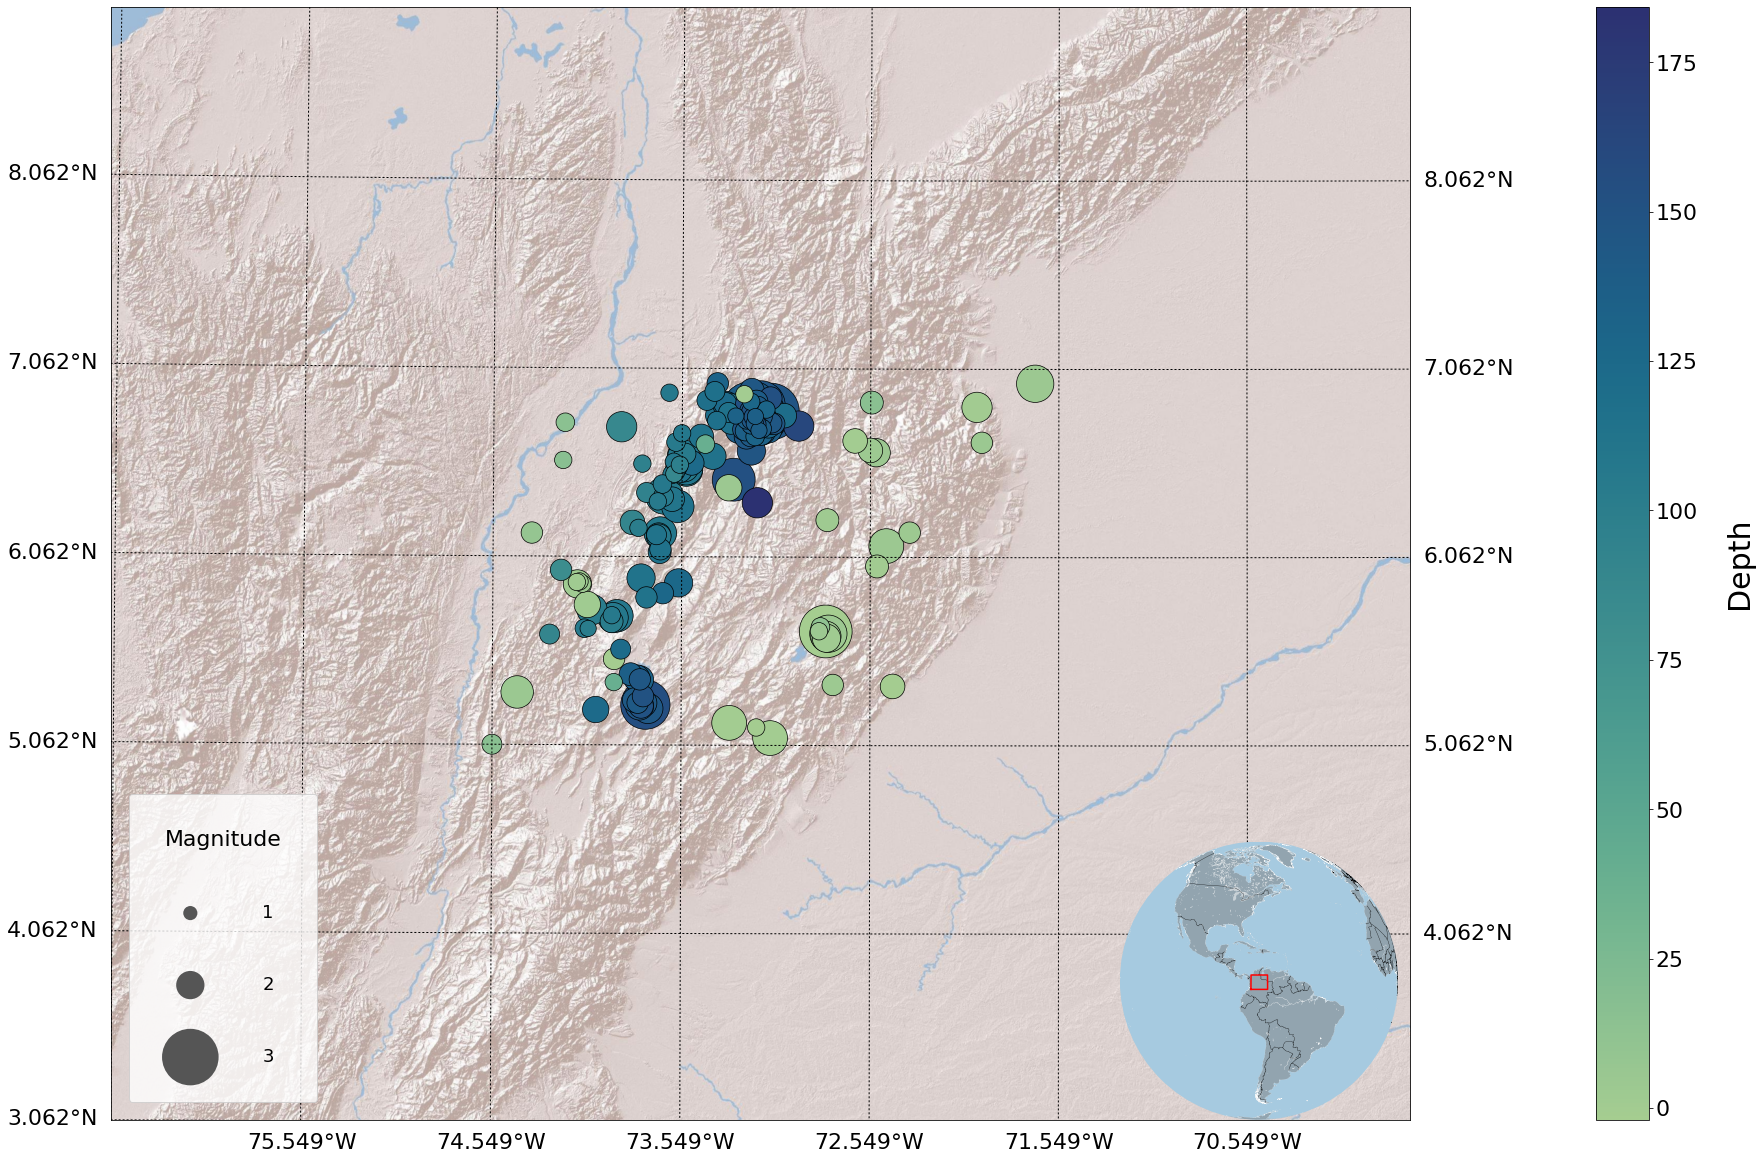

In [16]:
m, ax1, m2, ax2 = plot_eqt(df_all, edgecolors='black', linewidths=0.7)
plt.show()

## 5.3. Mapa sismos y estaciones

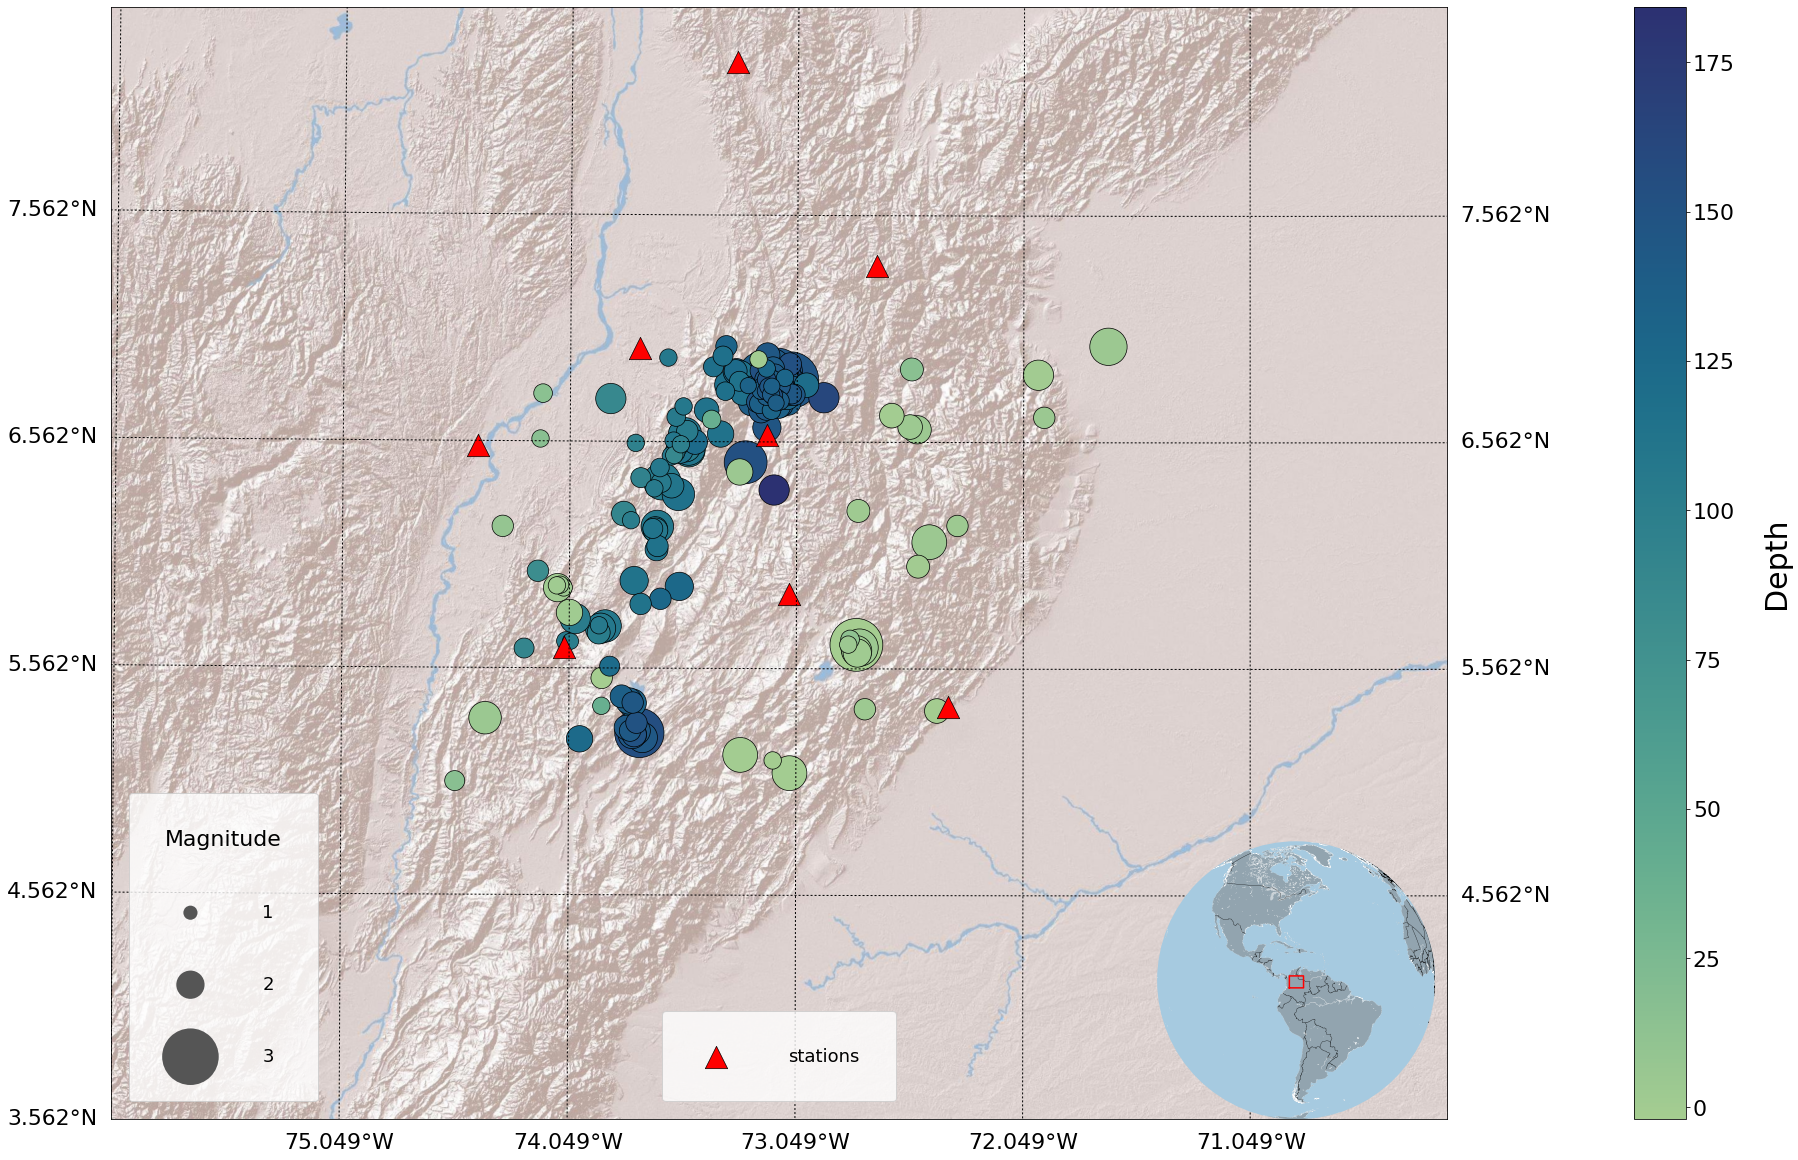

In [18]:
m, ax1, m2, ax2 = plot_eqt(df_all, df_sta=df_sta, station_legend=True, 
                           edgecolors='black', linewidths=0.7, ds=1.5)
plt.show()